torch.Size([61, 256, 256])


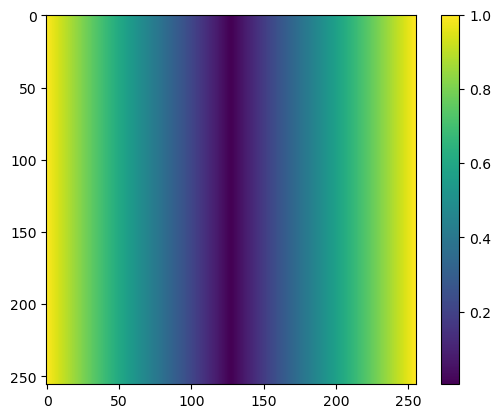

/tmp/ipykernel_7876/3493867131.py:546: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tilt_angles = torch.tensor(tilt_angles, dtype=torch.float32)


In [2]:
from  skimage.transform import resize
import torch
import tomopy
import numpy as np
import mrcfile
import odl
from odl import Operator
import matplotlib.pyplot as plt
from ODLHelper import OperatorFunction

# 设置设备
torch_type = torch.float
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# 固定随机种子
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)


def compute_snr(reconstructed, ground_truth):
    """
    计算信噪比 (SNR, Signal-to-Noise Ratio)
    
    参数：
        reconstructed: 3D 重建体积 (torch.Tensor)
        ground_truth:  3D 真实体积 (torch.Tensor)
    
    返回：
        snr_value: 计算得到的 SNR 值 (dB)
    """
    # 计算信号能量（Ground Truth 方差）
    signal_power = torch.var(ground_truth)

    # 计算噪声能量（误差方差）
    noise = reconstructed - ground_truth
    noise_power = torch.var(noise)

    # 避免除零错误
    if noise_power == 0:
        return float('inf')  # 如果没有噪声，SNR 是无穷大
    
    # 计算 SNR (dB)
    snr_value = 10 * torch.log10(signal_power / noise_power)
    
    return snr_value.item()  # 转换为 Python 浮点数


# 可视化重建结果
def visualize_volume(volume, slice_dim=0, slice_index=None, title="Volume Slice", cmap="gray"):
    if isinstance(volume, torch.Tensor):
        volume = volume.detach().cpu().numpy()
    if slice_index is None:
        slice_index = volume.shape[slice_dim] // 2
    if slice_dim == 0:
        slice_data = volume[slice_index, :, :]
    elif slice_dim == 1:
        slice_data = volume[:, slice_index, :]
    elif slice_dim == 2:
        slice_data = volume[:, :, slice_index]
    else:
        raise ValueError("slice_dim must be 0, 1, or 2.")
    plt.figure(figsize=(6, 6))
    plt.imshow(slice_data, cmap=cmap)
    plt.title(f"{title} (Dim {slice_dim}, Slice {slice_index})")
    plt.colorbar()
    plt.show()

# 显示重建的中间切片
# visualize_volume(vol_est, slice_dim=0, title="Reconstructed Volume (Middle Slice)")

class ParallelBeamGeometry3DOp(object):
    def __init__(self, img_size, num_angles=61, angle_max=np.pi/3, fact=1):
        self.img_size = img_size
        self.num_angles = num_angles

        # 定义重建体积 (90, 256, 256)
        self.reco_space = odl.uniform_discr(
            min_pt=[-0.5*img_size[0]/img_size[2], -0.5, -0.5],
            max_pt=[0.5*img_size[0]/img_size[2], 0.5, 0.5],
            shape=[img_size[0], img_size[1], img_size[2]],  # 90 x 256 x 256
            dtype='float32'
        )

        # 角度分区
        self.angle_partition = odl.uniform_partition(-angle_max, angle_max, num_angles)

        # 探测器分区，适配 256x256 探测器
        self.detector_partition = odl.uniform_partition(
            [-0.5, -0.5], [0.5, 0.5], [fact * img_size[1], fact * img_size[2]]  # 256 x 256
        )

        # 几何结构
        self.geometry = odl.tomo.Parallel3dAxisGeometry(
            self.angle_partition,
            self.detector_partition,
            axis=(0, 0, -1),
            det_axes_init=[(0, 0, 1), (0, 1, 0)],
            det_pos_init=(1, 0, 0)
        )

        self.num_detectors_x, self.num_detectors_y = self.geometry.detector.shape
        self.angles = self.geometry.angles
        self.optimizable_params = torch.tensor(self.angles, dtype=torch.float32)

        self.op = odl.tomo.RayTransform(self.reco_space, self.geometry, impl='astra_cuda')
        self.fbp = odl.tomo.analytic.filtered_back_projection.fbp_op(self.op)

    def __call__(self, x):
        return OperatorFunction.apply(self.op, x)

    def pinv(self, y):
        return OperatorFunction.apply(self.fbp, y)

    def adjoint(self, x):
        return OperatorFunction.apply(self.op.adjoint, x)
class MyNet(torch.nn.Module):
    def __init__(self, initial_guess):
        super(MyNet, self).__init__()
        self.filter = torch.nn.Parameter(initial_guess.clone())

    # Apply the filter to the input
    def forward(self, x):
        return (torch.fft.ifftn(torch.fft.fftn(x, dim=(-2,-1)) * self.filter, dim=(-2,-1))).real


import matplotlib.pyplot as plt

def plot_three_volumes(vol1, vol2, vol3, slice_dim=0, titles=("Pseudoinverse", "Reconstruction", "Ground Truth")):
    """
    将三个 3D 体数据的某个切片并排可视化。

    参数：
    vol1, vol2, vol3: 3D 体数据（Tensor 或 numpy array）
    slice_dim: 切片维度 (默认取第 0 维的中间层)
    titles: 图像标题
    """

    # 取 3D 体数据的中间切片索引
    mid_slice1 = vol1.shape[slice_dim] // 2
    mid_slice2 = vol2.shape[slice_dim] // 2
    mid_slice3 = vol3.shape[slice_dim] // 2

    # 确保张量不计算梯度
    vol1, vol2, vol3 = vol1.detach().cpu(), vol2.detach().cpu(), vol3.detach().cpu()

    if slice_dim == 0:
        img1 = vol1[mid_slice1].numpy()
        img2 = vol2[mid_slice2].numpy()
        img3 = vol3[mid_slice3].numpy()
    elif slice_dim == 1:
        img1 = vol1[:, mid_slice1, :].numpy()
        img2 = vol2[:, mid_slice2, :].numpy()
        img3 = vol3[:, mid_slice3, :].numpy()
    elif slice_dim == 2:
        img1 = vol1[:, :, mid_slice1].numpy()
        img2 = vol2[:, :, mid_slice2].numpy()
        img3 = vol3[:, :, mid_slice3].numpy()
    else:
        raise ValueError("slice_dim 只能是 0, 1, 2")

    # 绘图
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img1, cmap="gray")
    axes[0].set_title(titles[0])
    axes[0].axis("off")

    axes[1].imshow(img2, cmap="gray")
    axes[1].set_title(titles[1])
    axes[1].axis("off")

    axes[2].imshow(img3, cmap="gray")
    axes[2].set_title(titles[2])
    axes[2].axis("off")

    plt.show()
    
def plot_four_volumes(vol1, vol2, vol3, vol4, slice_dim=0, 
                      titles=("Pseudoinverse", "Reconstruction", "Direct Projection", "Ground Truth")):
    """
    将四个 3D 体数据的某个切片并排可视化。

    参数：
    vol1, vol2, vol3, vol4: 3D 体数据（Tensor 或 numpy array）
    slice_dim: 切片维度 (默认取第 0 维的中间层)
    titles: 图像标题 (长度必须为 4)
    """

    # 取 3D 体数据的中间切片索引
    mid_slice1 = vol1.shape[slice_dim] // 2
    mid_slice2 = vol2.shape[slice_dim] // 2
    mid_slice3 = vol3.shape[slice_dim] // 2
    mid_slice4 = vol4.shape[slice_dim] // 2

    # 确保张量不计算梯度
    vol1, vol2, vol3, vol4 = vol1.detach().cpu(), vol2.detach().cpu(), vol3.detach().cpu(), vol4.detach().cpu()

    if slice_dim == 0:
        img1 = vol1[mid_slice1].numpy()
        img2 = vol2[mid_slice2].numpy()
        img3 = vol3[mid_slice3].numpy()
        img4 = vol4[mid_slice4].numpy()
    elif slice_dim == 1:
        img1 = vol1[:, mid_slice1, :].numpy()
        img2 = vol2[:, mid_slice2, :].numpy()
        img3 = vol3[:, mid_slice3, :].numpy()
        img4 = vol4[:, mid_slice4, :].numpy()
    elif slice_dim == 2:
        img1 = vol1[:, :, mid_slice1].numpy()
        img2 = vol2[:, :, mid_slice2].numpy()
        img3 = vol3[:, :, mid_slice3].numpy()
        img4 = vol4[:, :, mid_slice4].numpy()
    else:
        raise ValueError("slice_dim 只能是 0, 1, 2")

    # 绘图
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    im0 = axes[0].imshow(img1, cmap="gray")
    axes[0].set_title(titles[0])
    axes[0].axis("off")
    fig.colorbar(im0, ax=axes[0])  # ✅ 正确

    im1 = axes[1].imshow(img2, cmap="gray")
    axes[1].set_title(titles[1])
    axes[1].axis("off")
    fig.colorbar(im1, ax=axes[1])  # ✅ 正确

    im2 = axes[2].imshow(img3, cmap="gray")
    axes[2].set_title(titles[2])
    axes[2].axis("off")
    fig.colorbar(im2, ax=axes[2])  # ✅ 正确

    im3 = axes[3].imshow(img4, cmap="gray")
    axes[3].set_title(titles[3])
    axes[3].axis("off")
    fig.colorbar(im3, ax=axes[3])  # ✅ 正确

    plt.show()


    
def create_ramp_filter_matrix2(size):
    """
    Create a ramp filter matrix for pointwise multiplication in the frequency domain.
    
    Args:
        size (int): Size of the filter (must match the size of the projection).
        
    Returns:
        np.ndarray: A ramp filter matrix of shape (size, size).
    """
    # Frequency indices (normalized)
    freqs = np.fft.fftfreq(size).reshape(1, -1)  # Shape: (1, size)

    # Create ramp filter: |f| for each frequency
    ramp_filter_1d = np.abs(freqs)

    # Create 2D ramp filter matrix by repeating along one dimension
    ramp_filter_matrix2 = np.tile(ramp_filter_1d, (size, 1))  # Shape: (size, size)
    
    return ramp_filter_matrix2

def create_ramp_filter_matrix3(size):
    """
    Create a 2D ramp filter matrix considering radial frequency.

    Args:
        size (int): Size of the filter (must match the size of the projection).

    Returns:
        np.ndarray: A 2D ramp filter matrix of shape (size, size).
    """
    # Generate frequency indices
    freqs = np.fft.fftfreq(size)  # 1D frequency components
    u, v = np.meshgrid(freqs, freqs)  # Create a 2D grid of frequencies

    # Compute radial frequency |f| = sqrt(u^2 + v^2)
    radial_freqs = np.sqrt(u**2 + v**2)

    # Create ramp filter based on radial frequencies
    ramp_filter_matrix3 = np.abs(radial_freqs)

    return ramp_filter_matrix3


def create_spherical_mask(shape, radius):
    """
    Create a spherical mask for a 3D volume.

    Args:
        shape (tuple): Shape of the 3D volume (z, y, x).
        radius (float): Radius of the sphere in voxel units.

    Returns:
        torch.Tensor: A 3D binary mask with 1 inside the sphere and 0 outside.
    """
    z, y, x = torch.meshgrid(
        torch.arange(shape[0]),
        torch.arange(shape[1]),
        torch.arange(shape[2]),
        indexing='ij'
    )

    # Calculate the center of the volume
    center = [dim // 2 for dim in shape]

    # Compute distance from the center for each voxel
    distance = torch.sqrt((z - center[0])**2 + (y - center[1])**2 + (x - center[2])**2)

    # Create mask: 1 inside the sphere, 0 outside
    mask = (distance <= radius).float()
    return mask

class MyNet1D_2D(torch.nn.Module):
    def __init__(self, initial_guess_angle, initial_guess_xy):
        super(MyNet1D_2D, self).__init__()
        # 定义 Angle 方向的1D滤波器参数
        # filter_angle: (D,)
        self.filter_angle = torch.nn.Parameter(initial_guess_angle.clone())    # 形状: (D,)

        # 定义 X和Y平面上的2D滤波器参数
        # filter_xy: (F1, F2)
        self.filter_xy = torch.nn.Parameter(initial_guess_xy.clone())          # 形状: (F1, F2)

    def forward(self, x):
        """
        前向传播过程：
        1. 对 Angle 方向进行 FFT 并应用1D滤波器。
        2. 对 X和Y方向进行 FFT 并应用2D滤波器。
        3. 逆 FFT 还原。
        
        输入:
            x: 3D 张量，形状为 (D, F1, F2)
        输出:
            x_recon: 3D 张量，形状为 (D, F1, F2)
        """

        # # # 1. 角度方向 (D) 进行 FFT
        X_fft_d = torch.fft.fft(x, dim=0)  # 形状: (D, F1, F2), 复数
        # 应用 Angle 方向的1D滤波器
        filter_angle = self.filter_angle.view(-1, 1, 1)  # 形状: (D, 1, 1)
        X_fft_d_filtered = X_fft_d * filter_angle          # 形状: (D, F1, F2), 复数
        # 逆 FFT
        X_ifft_d = torch.fft.ifft(X_fft_d_filtered, dim=0).real  # 形状: (D, F1, F2), 实数

        # 2. X和Y方向 (F1, F2) 进行 FFT
        X_fft_xy = torch.fft.fft2(X_ifft_d, dim=(1, 2))       # 形状: (D, F1, F2), 复数
        # 应用 XY 平面的2D滤波器
        filter_xy = self.filter_xy        # 形状: (1, F1, F2)
        X_fft_xy_filtered = X_fft_xy * filter_xy             # 形状: (D, F1, F2), 复数
        # 逆 FFT
        X_ifft_xy = torch.fft.ifft2(X_fft_xy_filtered, dim=(1, 2)).real  # 形状: (D, F1, F2), 实数

        return X_ifft_xy

Nangles = 61
op = ParallelBeamGeometry3DOp((90,256,256), num_angles=Nangles, angle_max=np.pi/3)

# 定义掩膜
def create_spherical_mask(shape, radius):
    z, y, x = torch.meshgrid(
        torch.arange(shape[0]),
        torch.arange(shape[1]),
        torch.arange(shape[2]),
        indexing='ij'
    )
    center = [dim // 2 for dim in shape]
    distance = torch.sqrt((z - center[0])**2 + (y - center[1])**2 + (x - center[2])**2)
    mask = (distance <= radius).float()
    return mask

# radius = max(vol_gt_torch.shape) // 2
# mask = create_spherical_mask(vol_gt_torch.shape, radius).to(device)


learning_rate = 1e-4*6
# 创建模型并设置优化器

n = 256

initial_guess_x = torch.ones((Nangles))

ramp_x = torch.abs(torch.linspace(-1, 1, steps=n))  # 形状: (F1,)

# 2. 将斜坡扩展为2D滤波器，通过在y方向上重复斜坡
initial_guess_2d = ramp_x.unsqueeze(0).repeat(n, 1)  # 形状: (F2, F1)
initial_guess_2d = torch.fft.fftshift(initial_guess_2d)
# #worest result

def normalize_std(tensor):
    """ 使用标准差进行归一化: (tensor - min) / std """
    return (tensor - tensor.min()) / tensor.std()


def normalize_std_m0(tensor):
    tensor = tensor / tensor.std()
    return tensor - tensor.mean()

def normalize_01(tensor):
    """ 使用标准差进行归一化: (tensor - min) / std """
    return (tensor - tensor.min()) / (tensor.max() - tensor.min())


import torch
import torch.nn.functional as F

def gaussian_kernel_3d(channels, kernel_size=11, sigma=1.5):
    """ 生成 3D 高斯核 """
    coords = torch.arange(kernel_size, dtype=torch.float32) - kernel_size // 2
    g = torch.exp(-0.5 * (coords / sigma).pow(2))
    g /= g.sum()

    kernel_1d = g.view(1, 1, -1)
    kernel_3d = torch.matmul(kernel_1d.transpose(2, 0), kernel_1d) * kernel_1d
    kernel_3d = kernel_3d.expand(channels, 1, kernel_size, kernel_size, kernel_size)

    return kernel_3d

def ssim_3d(x, y, kernel_size=11, sigma=1.5, C1=1e-4, C2=9e-4):
    """ 计算 3D 结构相似性 SSIM """

    # 确保输入是 5D (batch, channels, D, H, W)
    if x.dim() == 4:  # (C, D, H, W) → (1, C, D, H, W)
        x, y = x.unsqueeze(0), y.unsqueeze(0)
    elif x.dim() == 3:  # (D, H, W) → (1, 1, D, H, W)
        x, y = x.unsqueeze(0).unsqueeze(0), y.unsqueeze(0).unsqueeze(0)

    channels = x.shape[1]
    kernel = gaussian_kernel_3d(channels, kernel_size, sigma).to(x.device)

    # 计算均值
    mu_x = F.conv3d(x, kernel, padding=kernel_size//2, groups=channels)
    mu_y = F.conv3d(y, kernel, padding=kernel_size//2, groups=channels)

    # 计算平方均值
    mu_x2, mu_y2 = mu_x.pow(2), mu_y.pow(2)
    mu_xy = mu_x * mu_y

    # 计算方差
    sigma_x2 = F.conv3d(x * x, kernel, padding=kernel_size//2, groups=channels) - mu_x2
    sigma_y2 = F.conv3d(y * y, kernel, padding=kernel_size//2, groups=channels) - mu_y2
    sigma_xy = F.conv3d(x * y, kernel, padding=kernel_size//2, groups=channels) - mu_xy

    # 计算 SSIM
    ssim_map = ((2 * mu_xy + C1) * (2 * sigma_xy + C2)) / ((mu_x2 + mu_y2 + C1) * (sigma_x2 + sigma_y2 + C2))

    return ssim_map.mean()  # 取全局平均 SSIM 值



def compute_snr(x_ref, x):
    """
    计算 SNR (信号与噪声比)，严格按照 sum(x_ref^2) / sum((x_ref - x)^2) 定义。

    参数：
        x_ref:  参考信号 (无噪声) - torch.Tensor
        x:      噪声信号 (含噪声) - torch.Tensor

    返回：
        snr_value: 计算得到的 SNR (dB)
    """
    dif = torch.sum((x_ref - x) ** 2)  # 计算误差平方和
    nref = torch.sum(x_ref ** 2)  # 计算参考信号的平方和

    snr_value = 10 * torch.log10((nref + 1e-16) / (dif + 1e-16))  # 避免除零错误
    return snr_value.item()



def add_noise_with_snr(signal, snr_db):
    """
    给信号添加高斯噪声，使得 SNR 达到指定值（采用 sum(x_ref^2) / sum((x_ref - x)^2) 定义）。

    参数：
        signal (torch.Tensor): 无噪声信号。
        snr_db (float): 目标 SNR (dB)。

    返回：
        noisy_signal (torch.Tensor): 添加噪声后的信号。
    """
    nref = torch.sum(signal ** 2)  # 计算信号平方和
    snr_linear = 10 ** (snr_db / 10)  # SNR dB 转换为线性值
    noise_power = nref / snr_linear  # 计算目标噪声功率和

    noise = torch.randn_like(signal)  # 生成高斯噪声
    noise = noise * torch.sqrt(noise_power / (torch.sum(noise ** 2) + 1e-16))  # 调整噪声功率

    return signal + noise




# 给 projections_torch 添加噪声
# projections_torch_5 = add_noise_with_snr(projections_torch_0, 5)
# projections_torch_10 = add_noise_with_snr(projections_torch_0, 10)
# projections_torch_20 = add_noise_with_snr(projections_torch_0, 20)
# projections_torch_30 = add_noise_with_snr(projections_torch_0, 30)
# projections_torch_1 = add_noise_with_snr(projections_torch_0, 1)

# compute_snr(projections_torch_20,projections_torch_0)


class MyNet3D(torch.nn.Module):
    def __init__(self, initial_guess):
        super(MyNet3D, self).__init__()
        self.filter = torch.nn.Parameter(initial_guess.clone())
        # 计算 self.filter_xy 为 i = 0 到 60 的平均值
        self.filter_xy = self.filter.mean(dim=0)
        self.filter_angle = self.filter.mean(dim=(1, 2))

    # Apply the filter to the input
    def forward(self, x):
        return (torch.fft.ifftn(torch.fft.fftn(x, dim=(-2,-1)) * self.filter, dim=(-2,-1))).real
    

def normalize_nan(x, eps=1e-8):
    mean = x.mean()
    std = x.std()
    return (x - mean) / (std + eps)


class ParallelBeamGeometry3DOp(object):
    def __init__(self, img_size, tilt_angles, fact=1):
        """
        3D 平行束几何操作类，支持自定义角度列表

        参数:
        - img_size: (D, H, W) 形状的重建体积尺寸
        - tilt_angles: list 或 torch.Tensor, 自定义的投影角度（单位：弧度）
        - fact: int, 探测器分辨率缩放因子
        """
        self.img_size = img_size

        # 定义重建体积
        self.reco_space = odl.uniform_discr(
            min_pt=[-0.5 * img_size[0] / img_size[2], -0.5, -0.5],
            max_pt=[0.5 * img_size[0] / img_size[2], 0.5, 0.5],
            shape=[img_size[0], img_size[1], img_size[2]],  # (D, H, W)
            dtype='float32'
        )

        # 角度分区 (使用自定义角度)
        tilt_angles = torch.tensor(tilt_angles, dtype=torch.float32)
        self.angles_sorted, sorted_indices = torch.sort(tilt_angles)  # 角度排序
        self.angle_partition = odl.nonuniform_partition(self.angles_sorted.tolist())

        # 探测器分区
        self.detector_partition = odl.uniform_partition(
            [-0.5, -0.5], [0.5, 0.5], [fact * img_size[1], fact * img_size[2]]
        )

        # 几何结构
        self.geometry = odl.tomo.Parallel3dAxisGeometry(
            self.angle_partition,
            self.detector_partition,
            axis=(0, 0, -1),
            det_axes_init=[(0, 0, 1), (0, 1, 0)],
            det_pos_init=(1, 0, 0)
        )

        self.num_detectors_x, self.num_detectors_y = self.geometry.detector.shape
        self.optimizable_params = self.angles_sorted  # 存储已排序的角度

        # ODL + ASTRA
        self.op = odl.tomo.RayTransform(self.reco_space, self.geometry, impl='astra_cuda')
        self.fbp = odl.tomo.analytic.filtered_back_projection.fbp_op(self.op)

    def apply_angle_scaling(self, projections):
        """
        对投影进行横向拉伸补偿，并裁剪回原始大小
        - projections: (Nangles, H, W) 形状的投影数据 (torch.Tensor)
        """
        Nangles, H, W = projections.shape
        device = projections.device

        # 计算缩放因子：1 / cos(theta)
        scale_factors = 1.0 / torch.cos(self.angles_sorted).to(device)  # (Nangles,)
        scale_factors = scale_factors / 2 + 1 / 2  # 调整因子
        scale_factors = scale_factors / 2 + 1 / 2  # 进一步调整

        # 进行缩放
        projections_rescaled = []
        for i in range(Nangles):
            proj = projections[i].unsqueeze(0).unsqueeze(0)  # 变为 (1, 1, H, W)
            new_W = int(W * scale_factors[i])  # 计算缩放后宽度
            proj_rescaled = F.interpolate(proj, size=(H, new_W), mode='bilinear', align_corners=False)

            # **裁剪回原始大小**
            start_x = (new_W - W) // 2
            proj_cropped = proj_rescaled[:, :, :, start_x: start_x + W]  # 取中心部分

            projections_rescaled.append(proj_cropped.squeeze(0).squeeze(0))  # 去掉 batch 维度

        return torch.stack(projections_rescaled)  # (Nangles, H, W)

    def __call__(self, x):
        """
        计算投影，并应用横向缩放补偿
        """
        projections = OperatorFunction.apply(self.op, x)  # 原始投影
        # return self.apply_angle_scaling(projections)  # 返回矫正后的投影
        return projections

    def pinv(self, y):
        return OperatorFunction.apply(self.fbp, y)

    def adjoint(self, x):
        return OperatorFunction.apply(self.op.adjoint, x)




vol = np.load("model0_vol_gt.npy")
vol = torch.Tensor(vol).to(device)
vol = vol.moveaxis(1,2)
vol.size()

projection = np.load("model0_projections.npy")
projection = torch.Tensor(projection).to(device)
projection.size()


n = projection.size(2)
Nangles = projection.size(0)





tilt_angles_degrees = torch.linspace(60, -60, steps=61)


# **转换为弧度**
tilt_angles_radians = tilt_angles_degrees * (torch.pi / 180)
# **确保 tilt_angles 和 projection 同时按升序排列**
sorted_indices = torch.argsort(tilt_angles_radians)  # 获取排序索引
tilt_angles_radians_sorted = tilt_angles_radians[sorted_indices]  # 按索引排序角度
projection_sorted = projection[sorted_indices]  # 按索引排序投影数据


ramp_x = torch.abs(torch.linspace(-1, 1, steps=n))  # 形状: (F1,)
initial_guess_2d = ramp_x.unsqueeze(0).repeat(n, 1)  # 形状: (F2, F1)
initial_guess_2d = torch.fft.fftshift(initial_guess_2d)
initial_guess_3d_ramp = initial_guess_2d.unsqueeze(0).repeat(Nangles, 1, 1).to(device)
print(initial_guess_3d_ramp.shape)  # 应该是 (Nangles, 256, 256)
plt.imshow(torch.fft.fftshift(initial_guess_2d).cpu().detach().numpy())
plt.colorbar()
plt.show()

op = ParallelBeamGeometry3DOp(
    img_size=(vol.size(0), n, n), 
    tilt_angles=tilt_angles_radians_sorted
)

radius = max(vol.shape) // 2
mask = create_spherical_mask(vol.shape, radius).to(device)



## load data

In [3]:
modelS = torch.load("final_o_3d_p8e-5_tv_noisefree_all_ramp0.pth")
tiltS = torch.arange(-60, 60 + 2, 2)  # 结果 shape: (61,)
opS = ParallelBeamGeometry3DOp(
    # img_size=(140, 401, 301), 
    img_size=(90, 256, 256), 
    tilt_angles=tiltS * torch.pi / 180
)
volS = torch.tensor(np.load(f"model0_vol_gt.npy")).to(device).moveaxis(1, 2)
proS = torch.tensor(np.load(f"model0_projections.npy")).to(device)

###########################################

modelC = torch.load("final1_op_newtv_3d_p8e-5_tv_noisefree_all_ramp0.pth")
# modelC = torch.load("final_op_newtv_3d_p8e-5_tv_noisefree_all_ramp0.pth")
tiltC = torch.tensor([
    -52.01, -49.01, -46.01, -43.01, -40.01,
    -37.01, -34.01, -31.01, -28.01, -25.01,
    -22.01, -19.01, -16.01, -13.01, -10.01,
    -7.01,  -4.01,  -1.02,   1.99,   4.98,
     7.98,  10.99,  13.99,  16.99,  19.99,
    22.99,  25.99,  28.98,  31.99,  34.99,
    37.99,  40.98,  43.99,  46.99,  49.99
]).to(device)
opC = ParallelBeamGeometry3DOp(
    img_size=(90, 256, 256), 
    tilt_angles=tiltC * torch.pi / 180
)

# volC = 
proC = torch.tensor(np.load("chlamy_tomo24_ali_bin16.npy")).to(device)


import numpy as np
import matplotlib.pyplot as plt

def radial_profile(data, center=None):
    """
    计算二维数组的径向平均曲线
    参数:
      data: 2D numpy 数组
      center: 中心点 (y, x)，默认使用数组中心
    返回:
      一个 numpy 数组，表示不同半径处的平均值
    """
    y, x = np.indices(data.shape)
    if center is None:
        center = (data.shape[0] // 2, data.shape[1] // 2)
    # 计算每个像素到中心的距离
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    r_int = r.astype(np.int)  # 将半径取整作为 bin 的索引

    # 利用 np.bincount 对同一半径的像素进行求和和计数
    tbin = np.bincount(r_int.ravel(), data.ravel())
    nr = np.bincount(r_int.ravel())
    radialprofile = tbin / nr  # 求得平均值
    return radialprofile

def average_radial_profile(filter_vol):
    """
    对 3D 滤波器 volume (Nangles, Nx, Ny) 计算径向平均曲线，并对各角度取平均
    参数:
      filter_vol: numpy 数组，形状为 (Nangles, Nx, Ny)
    返回:
      平均的径向曲线 (1D numpy 数组)
    """
    profiles = []
    for i in range(filter_vol.shape[0]):
        profile = radial_profile(filter_vol[i])
        profiles.append(profile)
    profiles = np.array(profiles)
    mean_profile = profiles.mean(axis=0)
    return mean_profile




/tmp/ipykernel_7876/3155151936.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelS = torch.load("final_o_3d_p8e-5_tv_noisefree_all_ramp0.pth")
/tmp/ipykernel_7876/349

## for SHREC 2021

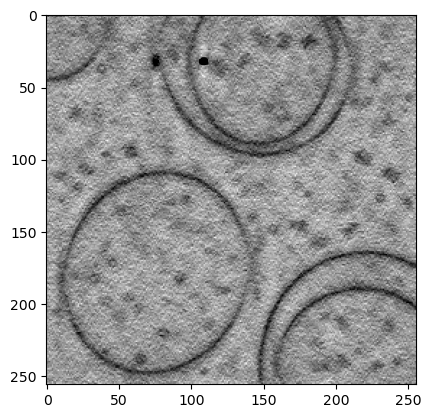

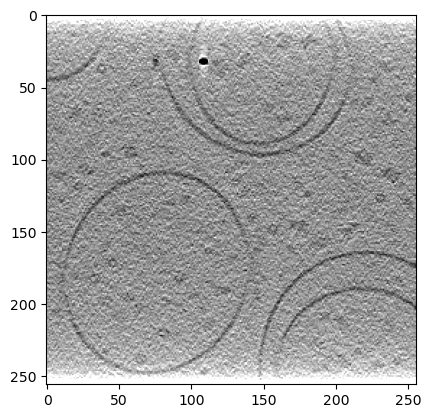

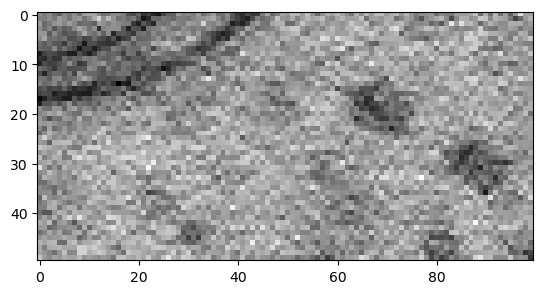

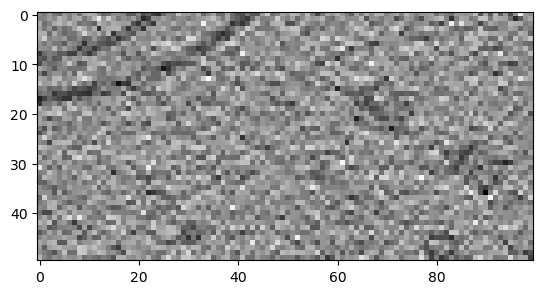

/tmp/ipykernel_7876/3155151936.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  r_int = r.astype(np.int)  # 将半径取整作为 bin 的索引


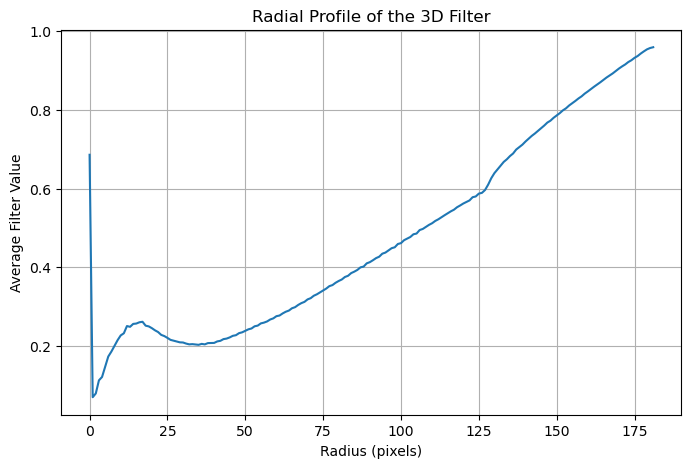

In [5]:
y_filteredS= modelS(proS)
vol_netS = opS.adjoint(y_filteredS)
vol_fbpS = opS.pinv((projection))

# plt.imshow(vol_netS[45,80:130,150:250,].cpu().detach().numpy(),"gray")
# plt.show()
# plt.imshow(vol_fbpS[45,80:130,150:250,].cpu().detach().numpy(),"gray")
# plt.show()

small_net_S = vol_netS[45,80:130,150:250,]
small_fbp_S = vol_fbpS[45,80:130,150:250,]

plt.imshow(vol_netS[45].cpu().detach().numpy(),"gray",vmin = small_net_S.min(),vmax = small_net_S.max())
plt.show()
plt.imshow(vol_fbpS[45].cpu().detach().numpy(),"gray",vmin = small_fbp_S.min(),vmax = small_fbp_S.max())
plt.show()

plt.imshow(vol_netS[45,80:130,150:250,].cpu().detach().numpy(),"gray")
plt.show()
plt.imshow(vol_fbpS[45,80:130,150:250,].cpu().detach().numpy(),"gray")
plt.show()



# 假设你的 3D 滤波器保存在 model1d.filter 中，形状为 (Nangles, Nx, Ny)
filter_vol_np = torch.fft.fftshift(modelS.filter).cpu().detach().numpy()  # 转换为 numpy 数组
mean_profile = average_radial_profile(filter_vol_np)

# 绘制径向平均曲线
plt.figure(figsize=(8, 5))
plt.plot(mean_profile)
plt.xlabel("Radius (pixels)")
plt.ylabel("Average Filter Value")
plt.title("Radial Profile of the 3D Filter")
plt.grid(True)
plt.show()

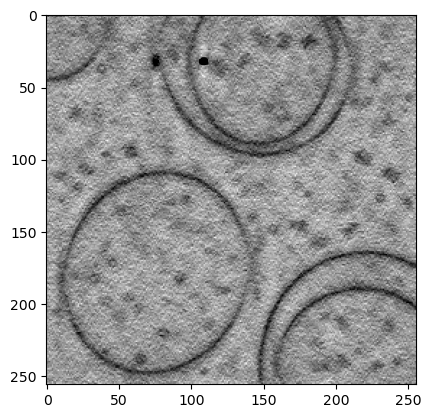

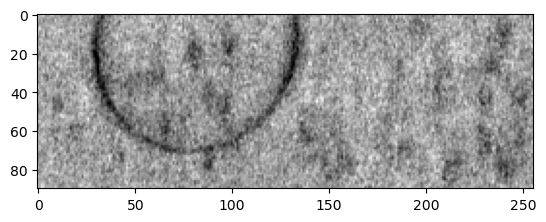

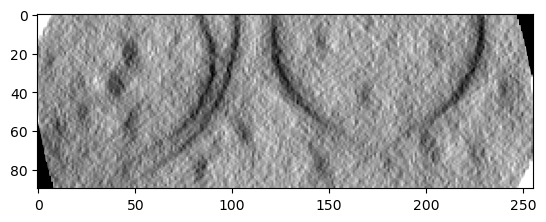

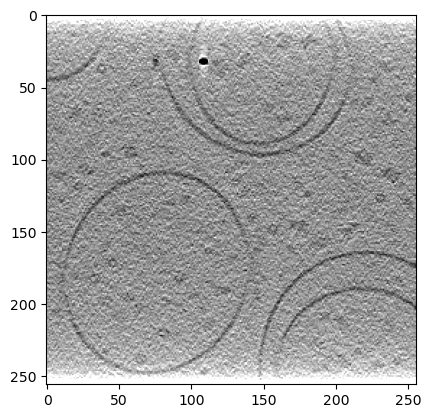

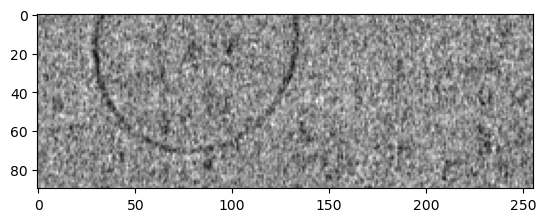

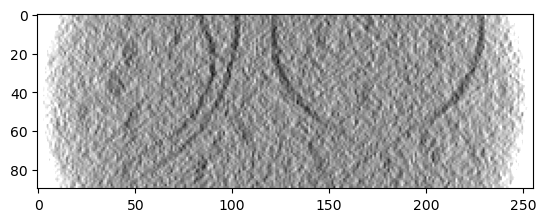

In [6]:
plt.imshow(vol_netS[45,:,:].cpu().detach().numpy(),"gray",vmin = small_net_S.min(),vmax = small_net_S.max())
plt.show()
plt.imshow(vol_netS[:,128,:].cpu().detach().numpy(),"gray",vmin = small_net_S.min(),vmax = small_net_S.max())
plt.show()
plt.imshow(vol_netS[:,:,128].cpu().detach().numpy(),"gray",vmin = small_net_S.min(),vmax = small_net_S.max())
plt.show()

plt.imshow(vol_fbpS[45,:,:].cpu().detach().numpy(),"gray",vmin = small_fbp_S.min(),vmax = small_fbp_S.max())
plt.show()
plt.imshow(vol_fbpS[:,128,:].cpu().detach().numpy(),"gray",vmin = small_fbp_S.min(),vmax = small_fbp_S.max())
plt.show()
plt.imshow(vol_fbpS[:,:,128].cpu().detach().numpy(),"gray",vmin = small_fbp_S.min(),vmax = small_fbp_S.max())
plt.show()

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def add_scale_bar(ax, pixel_size, length_in_nm, location=(0.05, 0.9), color='white', 
                  linewidth=3, bar_height=5, text_fontsize=16):
    """
    在指定的 Axes 上添加比例尺，单位为纳米 (nm)。
    
    参数：
      ax: matplotlib 的 Axes 对象
      pixel_size: 每个像素的尺寸（单位：Å）
      length_in_nm: 比例尺的实际长度（单位 nm）
      location: 比例尺在 Axes 内部的相对位置 (x, y)，表示从左下角开始的比例（0~1）
      color: 比例尺颜色
      linewidth: 比例尺线宽
      bar_height: 比例尺的高度（数据单位）
      text_fontsize: 标注文字的字号
    """
    # 将 length_in_nm 转换为 Å（1 nm = 10 Å）
    length_in_A = length_in_nm * 10
    # 根据像素大小计算比例尺长度对应的像素数
    length_in_pixels = length_in_A / pixel_size
    
    # 获取当前 Axes 的数据范围
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # 计算比例尺左下角的起始位置（数据坐标）
    x_start = xlim[0] + location[0] * (xlim[1] - xlim[0])
    y_start = ylim[1] - location[1] * (ylim[1] - ylim[0])
    
    # 添加一个矩形作为比例尺
    rect = patches.Rectangle((x_start, y_start - bar_height), length_in_pixels, bar_height, 
                             linewidth=linewidth, edgecolor=color, facecolor=color)
    ax.add_patch(rect)
    
    # 在比例尺上方添加加粗且放大的文字说明，显示单位为 nm
    ax.text(x_start + length_in_pixels / 2, y_start - bar_height - 2, f"{int(length_in_nm)} nm",
            color=color, ha='center', va='bottom', fontsize=text_fontsize, fontweight='bold')

# 保存全幅网络重建图像
fig, ax = plt.subplots()
im = ax.imshow(vol_netS[45].cpu().detach().numpy(), cmap="gray",
               vmin=small_net_S.min(), vmax=small_net_S.max())
add_scale_bar(ax, pixel_size=20, length_in_nm=100)  # 全幅图用100 nm比例尺，可根据需要调整
ax.axis('off')
plt.savefig("Snet.png", bbox_inches='tight', pad_inches=0)
plt.close(fig)

# 保存全幅 FBP 重建图像
fig, ax = plt.subplots()
im = ax.imshow(vol_fbpS[45].cpu().detach().numpy(), cmap="gray",
               vmin=small_fbp_S.min(), vmax=small_fbp_S.max())
add_scale_bar(ax, pixel_size=20, length_in_nm=100)
ax.axis('off')
plt.savefig("Sfbp.png", bbox_inches='tight', pad_inches=0)
plt.close(fig)

# 保存局部区域网络重建图像（裁剪区域）
fig, ax = plt.subplots()
im = ax.imshow(vol_netS[45,80:130,150:250].cpu().detach().numpy(), cmap="gray")
# 局部图采用较短的比例尺和较窄的 bar_height，文字字号设大一些
add_scale_bar(ax, pixel_size=20, length_in_nm=30, bar_height=2, text_fontsize=20)
ax.axis('off')
plt.savefig("Snetzoomed.png", bbox_inches='tight', pad_inches=0)
plt.close(fig)

# 保存局部区域 FBP 重建图像（裁剪区域）
fig, ax = plt.subplots()
im = ax.imshow(vol_fbpS[45,80:130,150:250].cpu().detach().numpy(), cmap="gray")
add_scale_bar(ax, pixel_size=20, length_in_nm=30, bar_height=2, text_fontsize=20)
ax.axis('off')
plt.savefig("Sfbpzoomed.png", bbox_inches='tight', pad_inches=0)
plt.close(fig)


In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def add_scale_bar(ax, pixel_size, length_in_nm, location=(0.05, 0.9), color='white', 
                  linewidth=3, bar_height=5, text_fontsize=16):
    """
    在指定的 Axes 上添加比例尺，单位为纳米 (nm)。
    
    参数：
      ax: matplotlib 的 Axes 对象
      pixel_size: 每个像素的尺寸（单位：Å）
      length_in_nm: 比例尺的实际长度（单位 nm）
      location: 比例尺在 Axes 内部的相对位置 (x, y)，表示从左下角开始的比例（0~1）
      color: 比例尺颜色
      linewidth: 比例尺线宽
      bar_height: 比例尺的高度（数据单位）
      text_fontsize: 标注文字的字号
    """
    # 将 length_in_nm 转换为 Å（1 nm = 10 Å）
    length_in_A = length_in_nm * 10
    # 根据像素大小计算比例尺长度对应的像素数
    length_in_pixels = length_in_A / pixel_size
    
    # 获取当前 Axes 的数据范围
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # 计算比例尺左下角的起始位置（数据坐标）
    x_start = xlim[0] + location[0] * (xlim[1] - xlim[0])
    y_start = ylim[1] - location[1] * (ylim[1] - ylim[0])
    
    # 添加一个矩形作为比例尺
    rect = patches.Rectangle((x_start, y_start - bar_height), length_in_pixels, bar_height, 
                             linewidth=linewidth, edgecolor=color, facecolor=color)
    ax.add_patch(rect)
    
    # 在比例尺上方添加加粗且放大的文字说明，显示单位为 nm
    ax.text(x_start + length_in_pixels / 2, y_start - bar_height - 2, f"{int(length_in_nm)} nm",
            color=color, ha='center', va='bottom', fontsize=text_fontsize, fontweight='bold')

# 保存全幅网络重建图像，并在图上标出 zoomed 区域（紫色矩形）
fig, ax = plt.subplots()
im = ax.imshow(vol_netS[45].cpu().detach().numpy(), cmap="gray",
               vmin=small_net_S.min(), vmax=small_net_S.max())
# 添加紫色矩形框（注意：imshow 中 x 对应数组第二维，y 对应第一维）
# zoomed 区域: 行 80 到 130，列 150 到 250
rect = patches.Rectangle((150, 80), 250-150, 130-80, linewidth=2, edgecolor='purple', facecolor='none')
ax.add_patch(rect)
# 添加比例尺
add_scale_bar(ax, pixel_size=20, length_in_nm=100)
ax.axis('off')
plt.savefig("Snet_with_box.png", bbox_inches='tight', pad_inches=0)
plt.close(fig)

# 保存全幅 FBP 重建图像，并在图上标出 zoomed 区域（紫色矩形框）
fig, ax = plt.subplots()
im = ax.imshow(vol_fbpS[45].cpu().detach().numpy(), cmap="gray",
               vmin=small_fbp_S.min(), vmax=small_fbp_S.max())
rect = patches.Rectangle((150, 80), 250-150, 130-80, linewidth=2, edgecolor='purple', facecolor='none')
ax.add_patch(rect)
add_scale_bar(ax, pixel_size=20, length_in_nm=100)
ax.axis('off')
plt.savefig("Sfbp_with_box.png", bbox_inches='tight', pad_inches=0)
plt.close(fig)

# 保存局部区域网络重建图像（裁剪区域）
fig, ax = plt.subplots()
im = ax.imshow(vol_netS[45,80:130,150:250].cpu().detach().numpy(), cmap="gray")
# 局部图采用较短的比例尺和较窄的 bar_height，文字字号设大一些
add_scale_bar(ax, pixel_size=20, length_in_nm=30, bar_height=2, text_fontsize=20)
ax.axis('off')
plt.savefig("Snetzoomed.png", bbox_inches='tight', pad_inches=0)
plt.close(fig)

# 保存局部区域 FBP 重建图像（裁剪区域）
fig, ax = plt.subplots()
im = ax.imshow(vol_fbpS[45,80:130,150:250].cpu().detach().numpy(), cmap="gray")
add_scale_bar(ax, pixel_size=20, length_in_nm=30, bar_height=2, text_fontsize=20)
ax.axis('off')
plt.savefig("Sfbpzoomed.png", bbox_inches='tight', pad_inches=0)
plt.close(fig)


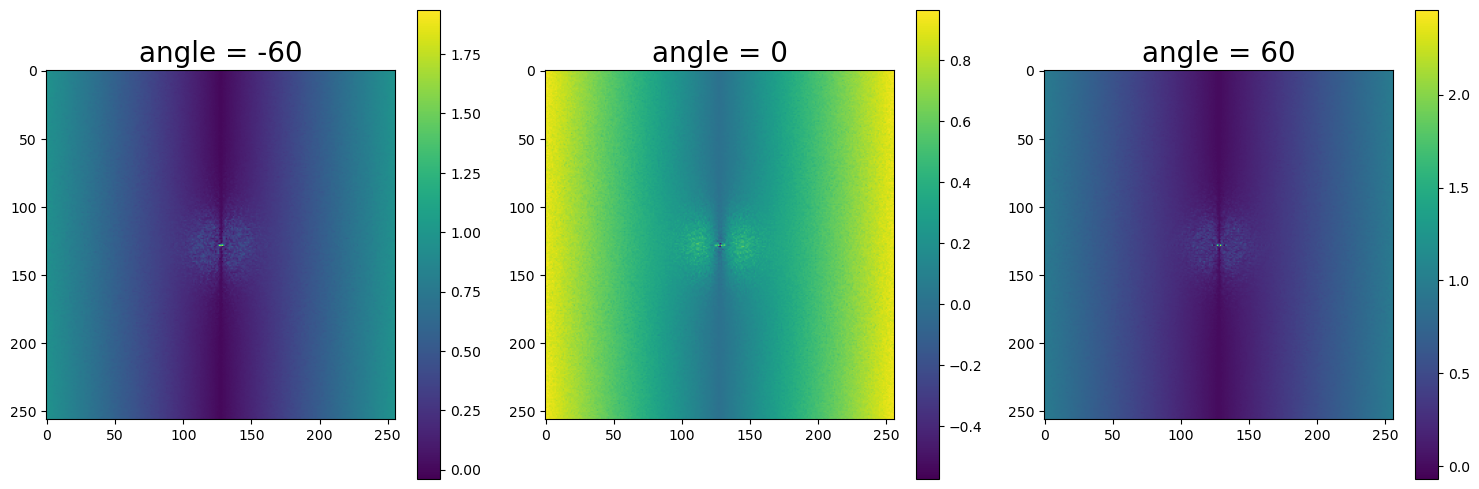

In [35]:
import matplotlib.pyplot as plt
import torch

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: filter at index 0
im0 = axes[0].imshow(torch.fft.fftshift(modelS.filter[0]).cpu().detach().numpy())
axes[0].set_title("angle = -60", fontsize=20)
fig.colorbar(im0, ax=axes[0])

# Plot 2: filter at index 30
im1 = axes[1].imshow(torch.fft.fftshift(modelS.filter[30]).cpu().detach().numpy())
axes[1].set_title("angle = 0", fontsize=20)
fig.colorbar(im1, ax=axes[1])

# Plot 3: filter at index -1
im2 = axes[2].imshow(torch.fft.fftshift(modelS.filter[-1]).cpu().detach().numpy())
axes[2].set_title("angle = 60", fontsize=20)
fig.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.savefig("filters_S.png", bbox_inches='tight', pad_inches=0)
plt.show()


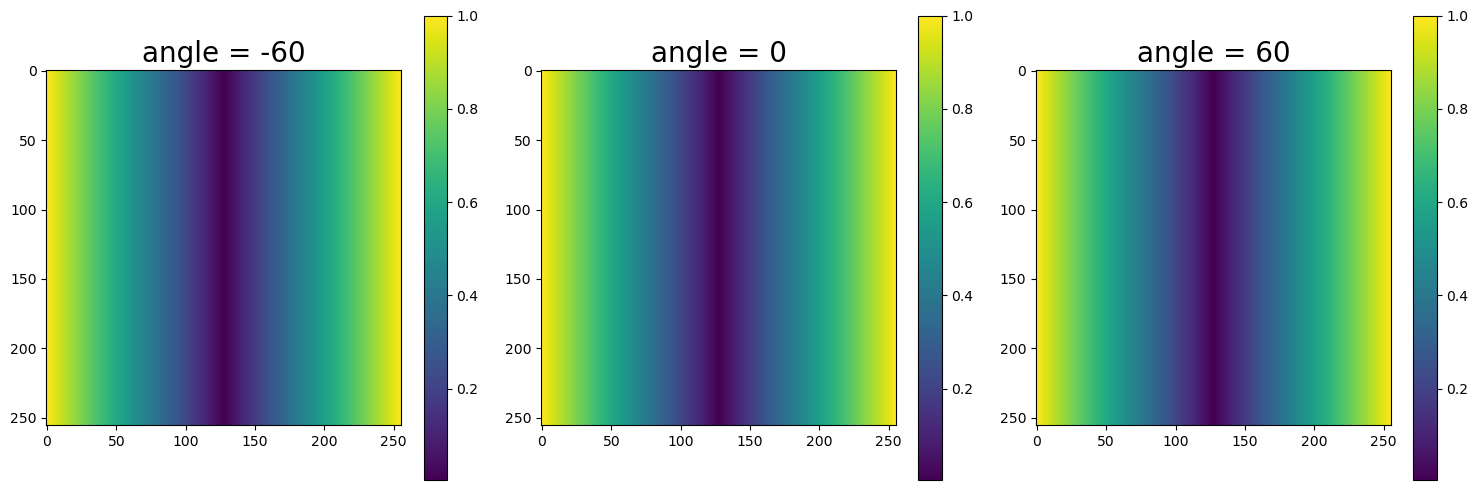

In [40]:
model1d = MyNet3D(initial_guess_3d_ramp).to(device)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: filter at index 0
im0 = axes[0].imshow(torch.fft.fftshift(model1d.filter[0]).cpu().detach().numpy())
axes[0].set_title("angle = -60", fontsize=20)
fig.colorbar(im0, ax=axes[0])

# Plot 2: filter at index 30
im1 = axes[1].imshow(torch.fft.fftshift(model1d.filter[30]).cpu().detach().numpy())
axes[1].set_title("angle = 0", fontsize=20)
fig.colorbar(im1, ax=axes[1])

# Plot 3: filter at index -1
im2 = axes[2].imshow(torch.fft.fftshift(model1d.filter[-1]).cpu().detach().numpy())
axes[2].set_title("angle = 60", fontsize=20)
fig.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.savefig("filters_S0.png", bbox_inches='tight', pad_inches=0)
plt.show()


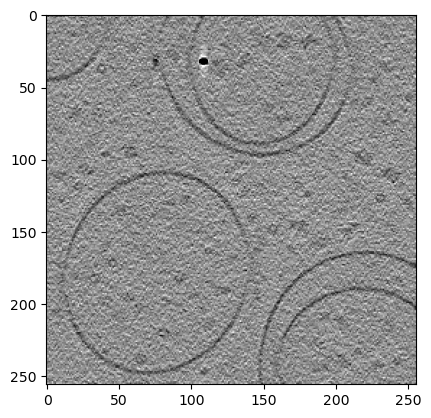

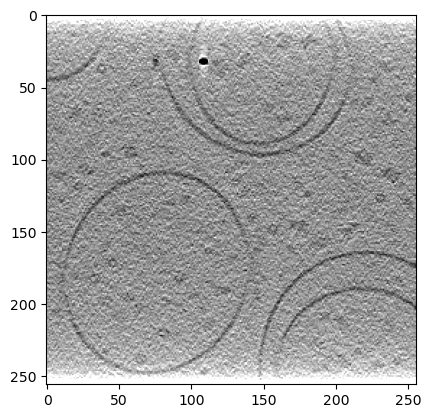

In [47]:
vol_netSramp = opS.adjoint(model1d(proS))
small_net_Sr = vol_netSramp[45,80:130,150:250]
plt.imshow(vol_netSramp[45,:,:].cpu().detach().numpy(),"gray",vmin = small_net_Sr.min(),vmax = small_net_Sr.max())
plt.show()

plt.imshow(vol_fbpS[45,:,:].cpu().detach().numpy(),"gray",vmin = small_fbp_S.min(),vmax = small_fbp_S.max())
plt.show()



## c

/tmp/ipykernel_7876/2064723349.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelC = torch.load("final3_op_newtv_3d_p8e-5_tv_noisefree_all_ramp0.pth")


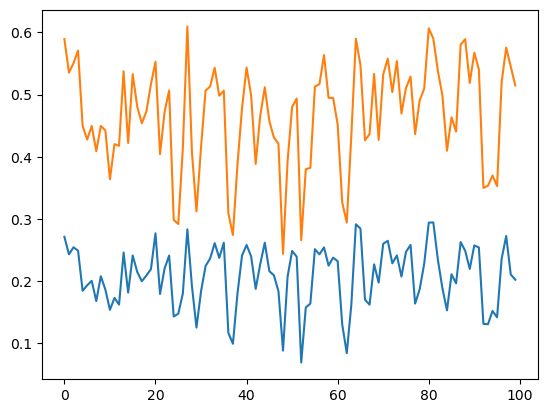

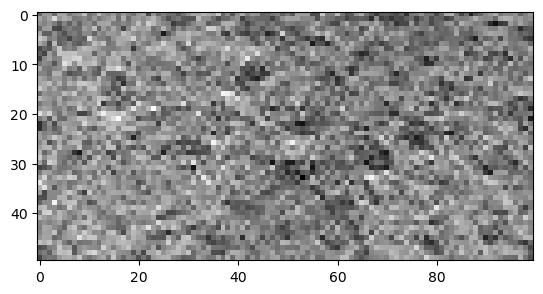

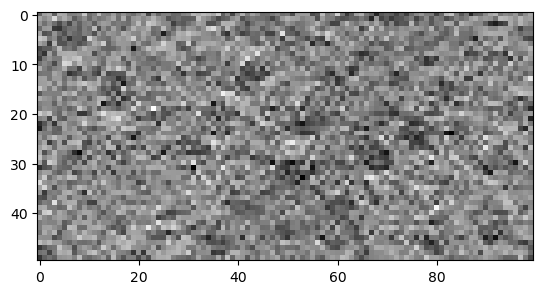

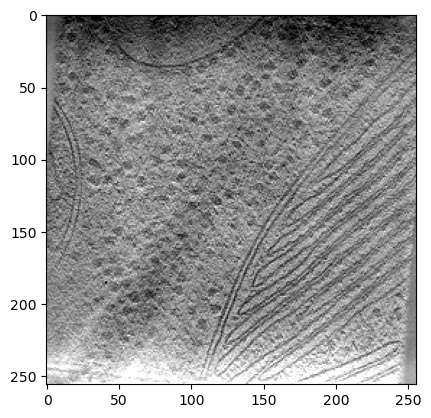

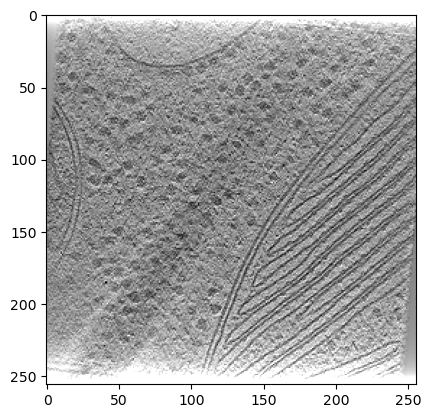

In [9]:
modelC = torch.load("final3_op_newtv_3d_p8e-5_tv_noisefree_all_ramp0.pth")



y_filteredC= modelC(proC)
vol_netC = opC.adjoint(y_filteredC)
vol_fbpC = opC.pinv(proC)


temp1 = vol_fbpC[45,:,:,].cpu().detach().numpy()
temp2 = vol_netC[45,:,:,].cpu().detach().numpy()

temp1 = normalize_01(temp1)
temp2 = normalize_01(temp2)

plt.plot(temp1[200,100:200])
plt.plot(temp2[200,100:200])
plt.show()


small_net_C = vol_netC[45,100:150,50:150,]
small_fbp_C = vol_fbpC[45,100:150,50:150,]

plt.imshow(vol_netC[45,100:150,50:150,].cpu().detach().numpy(),"gray")
plt.show()
plt.imshow(vol_fbpC[45,100:150,50:150,].cpu().detach().numpy(),"gray")
plt.show()


plt.imshow(vol_netC[45,].cpu().detach().numpy(),"gray",vmax = small_net_C.max(),vmin = small_net_C.min())
plt.show()
plt.imshow(vol_fbpC[45,].cpu().detach().numpy(),"gray",vmax = small_fbp_C.max(),vmin = small_fbp_C.min())
plt.show()


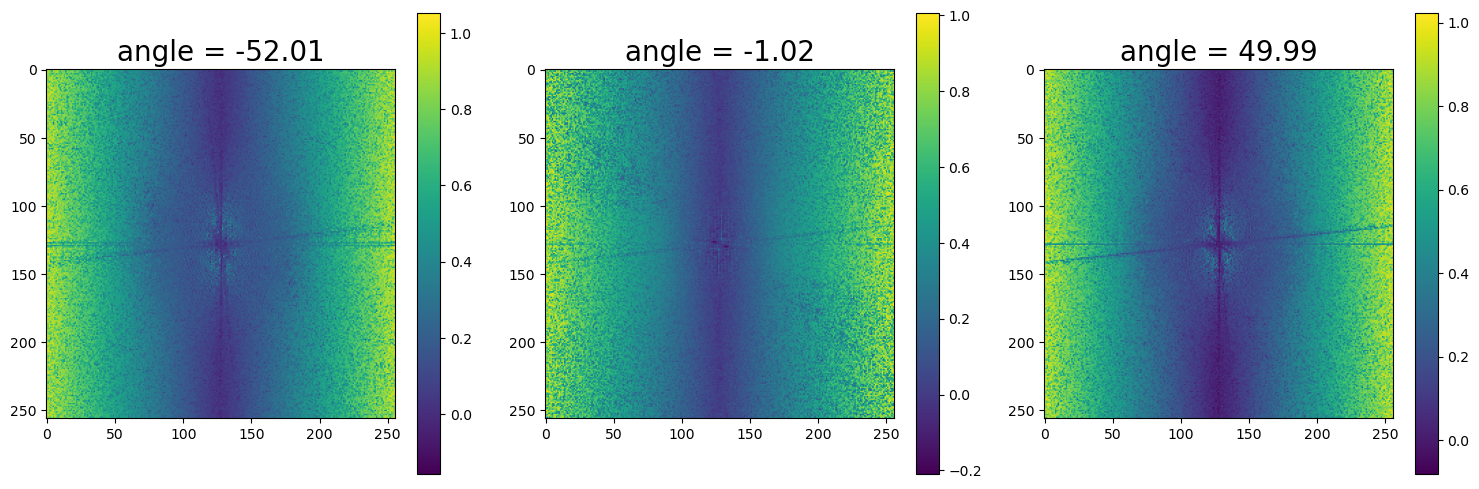

In [48]:
import matplotlib.pyplot as plt
import torch

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: filter at index 0
im0 = axes[0].imshow(torch.fft.fftshift(modelC.filter[0]).cpu().detach().numpy())
axes[0].set_title("angle = -52.01", fontsize=20)
fig.colorbar(im0, ax=axes[0])

# Plot 2: filter at index 30
im1 = axes[1].imshow(torch.fft.fftshift(modelC.filter[17]).cpu().detach().numpy())
axes[1].set_title("angle = -1.02", fontsize=20)
fig.colorbar(im1, ax=axes[1])

# Plot 3: filter at index -1
im2 = axes[2].imshow(torch.fft.fftshift(modelC.filter[-1]).cpu().detach().numpy())
axes[2].set_title("angle = 49.99", fontsize=20)
fig.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.savefig("filters_C.png", bbox_inches='tight', pad_inches=0)
plt.show()


In [14]:
# 定义局部区域变量（裁剪区域 [45,100:150,50:150]）
small_net_C = vol_netC[45, 100:150, 50:150]
small_fbp_C = vol_fbpC[45, 100:150, 50:150]

# 保存全幅网络重建图像，并在图上标出局部区域（紫色矩形）
fig, ax = plt.subplots()
im = ax.imshow(vol_netC[45].cpu().detach().numpy(), cmap="gray",
               vmin=small_net_C.min(), vmax=small_net_C.max())
# 局部区域: 行 100 到 150，列 50 到 150（注意：imshow 中 x 对应数组第二维，y 对应第一维）
rect = patches.Rectangle((50, 100), 150-50, 150-100, linewidth=2, edgecolor='purple', facecolor='none')
ax.add_patch(rect)
# 添加比例尺：像素大小为20 Å，对应100 nm的比例尺
add_scale_bar(ax, pixel_size=31.36, length_in_nm=150)
ax.axis('off')
plt.savefig("Cnet_with_box.png", bbox_inches='tight', pad_inches=0)
plt.close(fig)

# 保存全幅 FBP 重建图像，并在图上标出局部区域（紫色矩形）
fig, ax = plt.subplots()
im = ax.imshow(vol_fbpC[45].cpu().detach().numpy(), cmap="gray",
               vmin=small_fbp_C.min(), vmax=small_fbp_C.max())
rect = patches.Rectangle((50, 100), 150-50, 150-100, linewidth=2, edgecolor='purple', facecolor='none')
ax.add_patch(rect)
add_scale_bar(ax, pixel_size=31.36, length_in_nm=150)
ax.axis('off')
plt.savefig("Cfbp_with_box.png", bbox_inches='tight', pad_inches=0)
plt.close(fig)

# 保存局部区域网络重建图像（裁剪区域 [45,100:150,50:150]）
fig, ax = plt.subplots()
im = ax.imshow(vol_netC[45, 100:150, 50:150].cpu().detach().numpy(), cmap="gray")
# 局部图采用较短的比例尺和较窄的比例尺高度，同时文字字号调大
add_scale_bar(ax, pixel_size=31.36, length_in_nm=30, bar_height=2, text_fontsize=20)
ax.axis('off')
plt.savefig("Cnetzoomed.png", bbox_inches='tight', pad_inches=0)
plt.close(fig)

# 保存局部区域 FBP 重建图像（裁剪区域 [45,100:150,50:150]）
fig, ax = plt.subplots()
im = ax.imshow(vol_fbpC[45, 100:150, 50:150].cpu().detach().numpy(), cmap="gray")
add_scale_bar(ax, pixel_size=31.36, length_in_nm=30, bar_height=2, text_fontsize=20)
ax.axis('off')
plt.savefig("Cfbpzoomed.png", bbox_inches='tight', pad_inches=0)
plt.close(fig)


torch.Size([35, 256, 256])


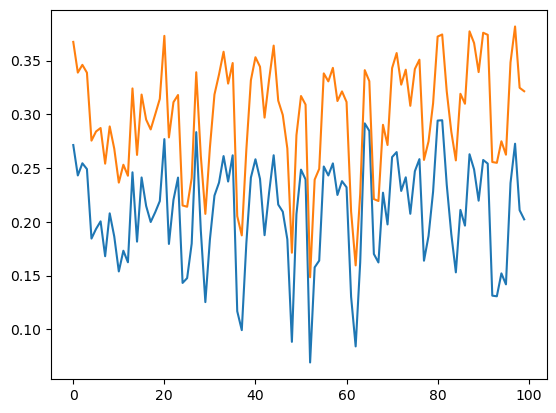

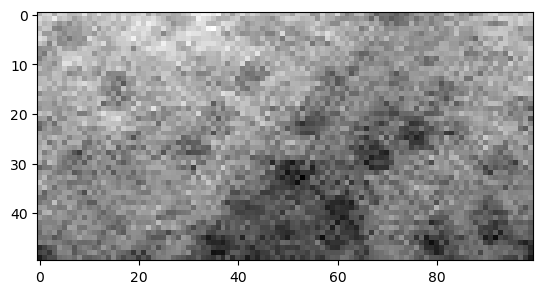

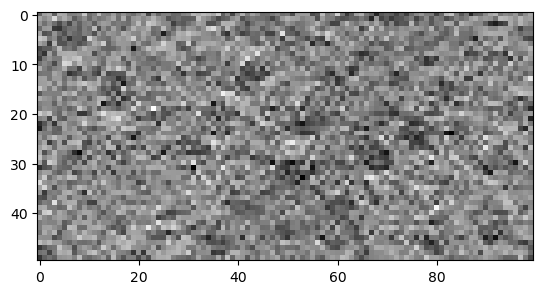

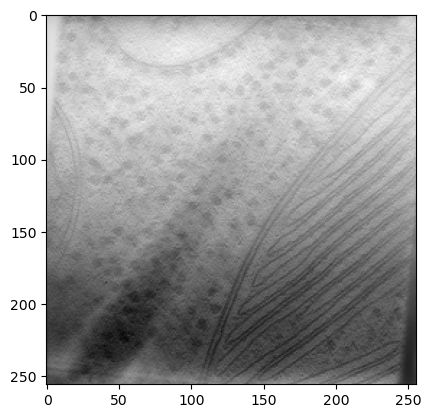

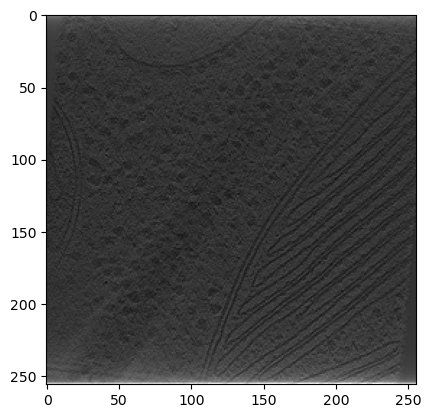

In [38]:
import numpy as np
import torch

def least_squares_interpolate_filter(temp, new_angles, old_start=60.0, step=2.0, poly_degree=4):
    """
    利用最小二乘法多项式拟合对滤波器进行插值。
    
    参数：
      temp: 原始滤波器，形状为 (N, H, W)，其中 N 表示角度数（例如 61）。
      new_angles: 新的角度 tensor，形状为 (M,)。
      old_start: 原始角度起始值（默认为 60）。
      step: 原始角度步长（默认为 2）。
      poly_degree: 多项式拟合的阶数（建议低阶，如 3 或 4）。
    
    返回：
      new_temp: 插值后的滤波器，形状为 (M, H, W)。
    """
    # 将 tensor 转换为 numpy 数组，并 detach 防止梯度追踪
    temp_np = temp.detach().cpu().numpy() if temp.is_cuda else temp.detach().numpy()
    N, H, W = temp_np.shape
    
    # 构造原始角度列表，从 60 到 -60（步长为 2）
    orig_angles = np.linspace(old_start, old_start - step * (N - 1), N)
    
    # 将 new_angles 转换为 numpy 数组
    new_angles_np = new_angles.detach().cpu().numpy() if new_angles.is_cuda else new_angles.detach().numpy()
    M = len(new_angles_np)
    
    # 初始化插值后的滤波器数组
    new_temp_np = np.empty((M, H, W), dtype=temp_np.dtype)
    
    # 对于每个像素 (x, y)，利用最小二乘法拟合多项式
    for i in range(H):
        for j in range(W):
            y_vals = temp_np[:, i, j]
            # 使用 numpy.polyfit 进行多项式最小二乘拟合
            coeffs = np.polyfit(orig_angles, y_vals, poly_degree)
            # 根据拟合的多项式求新角度处的值
            poly_val = np.polyval(coeffs, new_angles_np)
            new_temp_np[:, i, j] = poly_val
            
    # 转换回 torch tensor，并保持原设备
    new_temp = torch.from_numpy(new_temp_np).to(device)
    return new_temp

# 示例使用：
# 假设 temp 是已有的滤波器 tensor，形状为 (61, H, W)
new_tilt_angles_degrees = torch.tensor([
    -52.01, -49.01, -46.01, -43.01, -40.01,
    -37.01, -34.01, -31.01, -28.01, -25.01,
    -22.01, -19.01, -16.01, -13.01, -10.01,
    -7.01,  -4.01,  -1.02,   1.99,   4.98,
     7.98,  10.99,  13.99,  16.99,  19.99,
    22.99,  25.99,  28.98,  31.99,  34.99,
    37.99,  40.98,  43.99,  46.99,  49.99
]).to(device)

new_temp_leastsq = least_squares_interpolate_filter(modelS.filter, new_tilt_angles_degrees, poly_degree=10)
print(new_temp_leastsq.shape)

modelC_new = MyNet3D(new_temp_leastsq)

y_filteredC = modelC_new(proC)
vol_netC = opC.adjoint(y_filteredC)
vol_fbpC = opC.pinv(proC)


temp1 = vol_fbpC[45,:,:,].cpu().detach().numpy()
temp2 = vol_netC[45,:,:,].cpu().detach().numpy()

temp1 = normalize_01(temp1)
temp2 = normalize_01(temp2)

plt.plot(temp1[200,100:200])
plt.plot(temp2[200,100:200])
plt.show()

plt.imshow(vol_netC[45, 100:150, 50:150].cpu().detach().numpy(),"gray")
plt.show()
plt.imshow(vol_fbpC[45, 100:150, 50:150].cpu().detach().numpy(),"gray")
plt.show()


plt.imshow(vol_netC[45,].cpu().detach().numpy(),"gray")
plt.show()
plt.imshow(vol_fbpC[45,].cpu().detach().numpy(),"gray")
plt.show()



import matplotlib.pyplot as plt
import numpy as np

# Extract the specific slice from the tensor
slice_data = vol_netC[45, :, :].cpu().detach().numpy()

# Normalize the slice data to the range [0, 1]
norm_data = (slice_data - np.min(slice_data)) / (np.max(slice_data) - np.min(slice_data))

# Save the normalized slice as a PNG image using a grayscale colormap
plt.imsave('Cnet2.png', norm_data, cmap='gray')

# Extract the specific slice from the tensor
slice_data = vol_fbpC[45, :, :].cpu().detach().numpy()

# Normalize the slice data to the range [0, 1]
norm_data = (slice_data - np.min(slice_data)) / (np.max(slice_data) - np.min(slice_data))

# Save the normalized slice as a PNG image using a grayscale colormap
plt.imsave('Cfbp2.png', norm_data, cmap='gray')

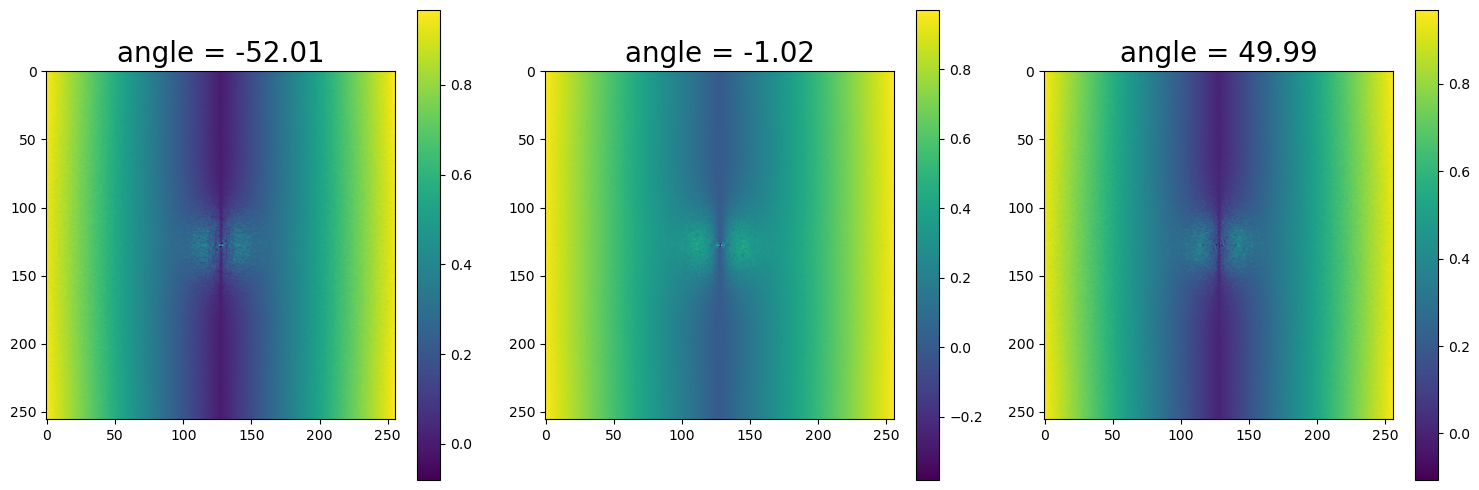

In [49]:
import matplotlib.pyplot as plt
import torch

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: filter at index 0
im0 = axes[0].imshow(torch.fft.fftshift(modelC_new.filter[0]).cpu().detach().numpy())
axes[0].set_title("angle = -52.01", fontsize=20)
fig.colorbar(im0, ax=axes[0])

# Plot 2: filter at index 30
im1 = axes[1].imshow(torch.fft.fftshift(modelC_new.filter[17]).cpu().detach().numpy())
axes[1].set_title("angle = -1.02", fontsize=20)
fig.colorbar(im1, ax=axes[1])

# Plot 3: filter at index -1
im2 = axes[2].imshow(torch.fft.fftshift(modelC_new.filter[-1]).cpu().detach().numpy())
axes[2].set_title("angle = 49.99", fontsize=20)
fig.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.savefig("filters_C2.png", bbox_inches='tight', pad_inches=0)
plt.show()

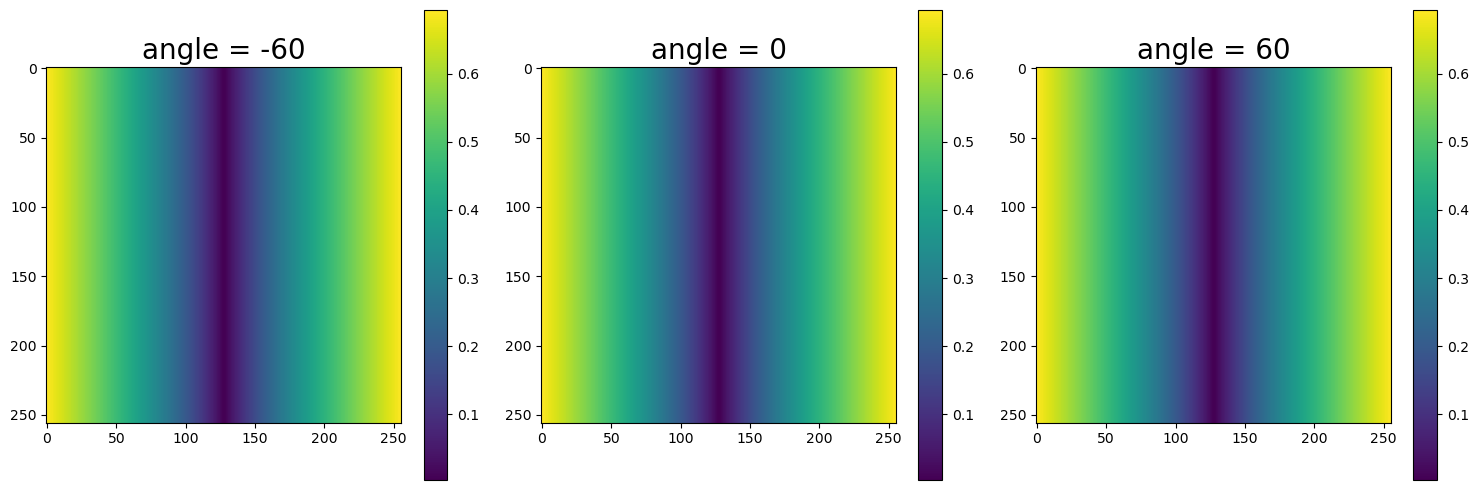

In [59]:
import matplotlib.pyplot as plt
import torch
import numpy as np

epsilon = 1  # Small constant to avoid log(0)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: filter at index 0 with log scaling
filter0 = torch.fft.fftshift(model1d.filter[0]).cpu().detach().numpy()
im0 = axes[0].imshow(np.log(np.abs(filter0) + epsilon))
axes[0].set_title("angle = -60", fontsize=20)
fig.colorbar(im0, ax=axes[0])

# Plot 2: filter at index 17 with log scaling
filter17 = torch.fft.fftshift(model1d.filter[30]).cpu().detach().numpy()
im1 = axes[1].imshow(np.log(np.abs(filter17) + epsilon))
axes[1].set_title("angle = 0", fontsize=20)
fig.colorbar(im1, ax=axes[1])

# Plot 3: filter at index -1 with log scaling
filter_last = torch.fft.fftshift(model1d.filter[-1]).cpu().detach().numpy()
im2 = axes[2].imshow(np.log(np.abs(filter_last) + epsilon))
axes[2].set_title("angle = 60", fontsize=20)
fig.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.savefig("filters_S0.png", bbox_inches='tight', pad_inches=0)
plt.show()


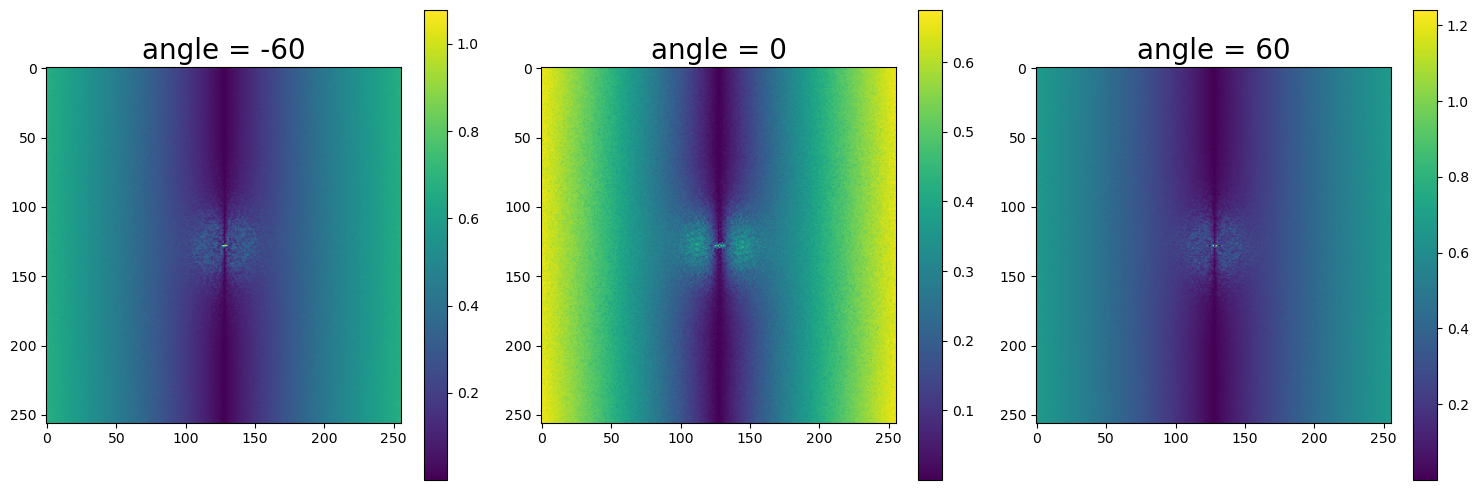

In [57]:
import matplotlib.pyplot as plt
import torch
import numpy as np

epsilon = 1  # Small constant to avoid log(0)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: filter at index 0 with log scaling
filter0 = torch.fft.fftshift(modelS.filter[0]).cpu().detach().numpy()
im0 = axes[0].imshow(np.log(np.abs(filter0) + epsilon))
axes[0].set_title("angle = -60", fontsize=20)
fig.colorbar(im0, ax=axes[0])

# Plot 2: filter at index 17 with log scaling
filter17 = torch.fft.fftshift(modelS.filter[30]).cpu().detach().numpy()
im1 = axes[1].imshow(np.log(np.abs(filter17) + epsilon))
axes[1].set_title("angle = 0", fontsize=20)
fig.colorbar(im1, ax=axes[1])

# Plot 3: filter at index -1 with log scaling
filter_last = torch.fft.fftshift(modelS.filter[-1]).cpu().detach().numpy()
im2 = axes[2].imshow(np.log(np.abs(filter_last) + epsilon))
axes[2].set_title("angle = 60", fontsize=20)
fig.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.savefig("filters_S.png", bbox_inches='tight', pad_inches=0)
plt.show()


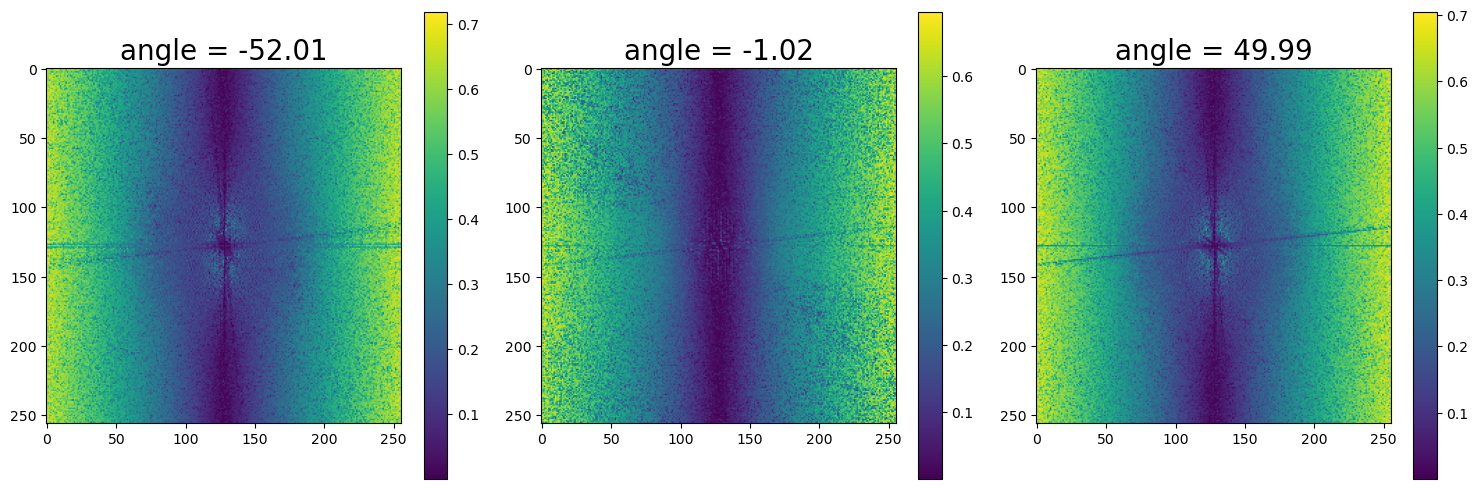

In [56]:
import matplotlib.pyplot as plt
import torch
import numpy as np

epsilon = 1  # Small constant to avoid log(0)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: filter at index 0 with log scaling
filter0 = torch.fft.fftshift(modelC.filter[0]).cpu().detach().numpy()
im0 = axes[0].imshow(np.log(np.abs(filter0) + epsilon))
axes[0].set_title("angle = -52.01", fontsize=20)
fig.colorbar(im0, ax=axes[0])

# Plot 2: filter at index 17 with log scaling
filter17 = torch.fft.fftshift(modelC.filter[17]).cpu().detach().numpy()
im1 = axes[1].imshow(np.log(np.abs(filter17) + epsilon))
axes[1].set_title("angle = -1.02", fontsize=20)
fig.colorbar(im1, ax=axes[1])

# Plot 3: filter at index -1 with log scaling
filter_last = torch.fft.fftshift(modelC.filter[-1]).cpu().detach().numpy()
im2 = axes[2].imshow(np.log(np.abs(filter_last) + epsilon))
axes[2].set_title("angle = 49.99", fontsize=20)
fig.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.savefig("filters_C.png", bbox_inches='tight', pad_inches=0)
plt.show()


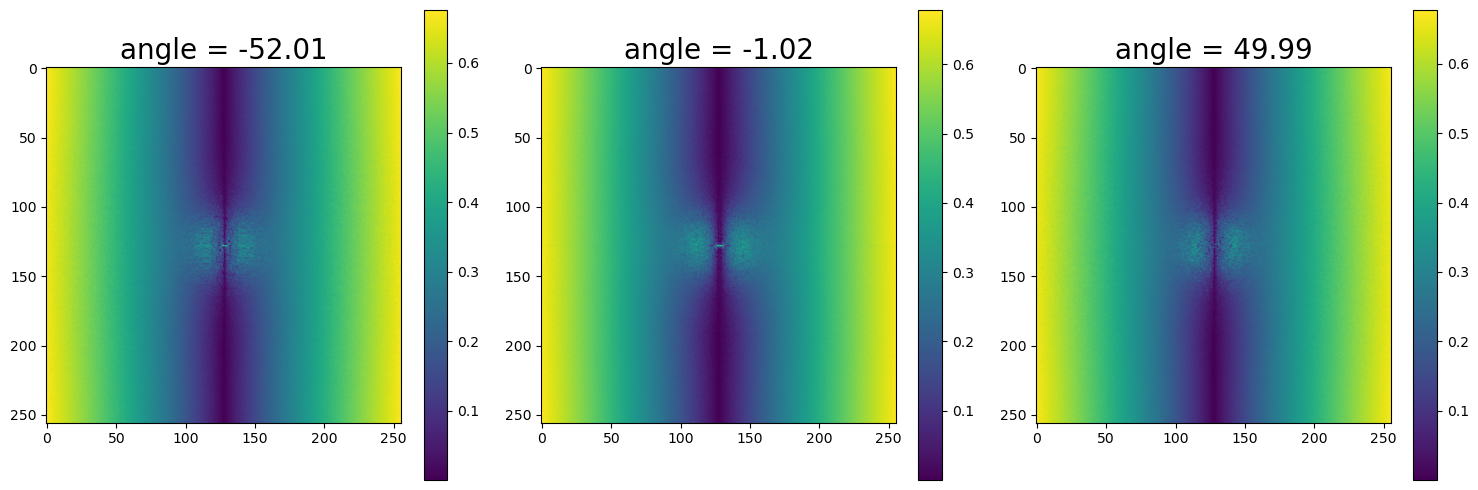

In [55]:
import matplotlib.pyplot as plt
import torch
import numpy as np

epsilon = 1  # Small constant to avoid log(0)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: filter at index 0 with log scaling
filter0 = torch.fft.fftshift(modelC_new.filter[0]).cpu().detach().numpy()
im0 = axes[0].imshow(np.log(np.abs(filter0) + epsilon))
axes[0].set_title("angle = -52.01", fontsize=20)
fig.colorbar(im0, ax=axes[0])

# Plot 2: filter at index 17 with log scaling
filter17 = torch.fft.fftshift(modelC_new.filter[17]).cpu().detach().numpy()
im1 = axes[1].imshow(np.log(np.abs(filter17) + epsilon))
axes[1].set_title("angle = -1.02", fontsize=20)
fig.colorbar(im1, ax=axes[1])

# Plot 3: filter at index -1 with log scaling
filter_last = torch.fft.fftshift(modelC_new.filter[-1]).cpu().detach().numpy()
im2 = axes[2].imshow(np.log(np.abs(filter_last) + epsilon))
axes[2].set_title("angle = 49.99", fontsize=20)
fig.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.savefig("filters_C2.png", bbox_inches='tight', pad_inches=0)
plt.show()


In [20]:
# 定义局部区域变量（裁剪区域 [45,100:150,50:150]）
small_net_C = vol_netC[45, 100:150, 50:150]
small_fbp_C = vol_fbpC[45, 100:150, 50:150]

# 保存全幅网络重建图像，并在图上标出局部区域（紫色矩形）
fig, ax = plt.subplots()
im = ax.imshow(vol_netC[45].cpu().detach().numpy(), cmap="gray")
# 局部区域: 行 100 到 150，列 50 到 150（注意：imshow 中 x 对应数组第二维，y 对应第一维）
rect = patches.Rectangle((50, 100), 150-50, 150-100, linewidth=2, edgecolor='purple', facecolor='none')
ax.add_patch(rect)
# 添加比例尺：像素大小为20 Å，对应100 nm的比例尺
add_scale_bar(ax, pixel_size=31.36, length_in_nm=150)
ax.axis('off')
plt.savefig("Cnet_with_box2.png", bbox_inches='tight', pad_inches=0)
plt.close(fig)

# 保存全幅 FBP 重建图像，并在图上标出局部区域（紫色矩形）
fig, ax = plt.subplots()
im = ax.imshow(vol_fbpC[45].cpu().detach().numpy(), cmap="gray",
               vmin=small_fbp_C.min(), vmax=small_fbp_C.max())
rect = patches.Rectangle((50, 100), 150-50, 150-100, linewidth=2, edgecolor='purple', facecolor='none')
ax.add_patch(rect)
add_scale_bar(ax, pixel_size=31.36, length_in_nm=150)
ax.axis('off')
plt.savefig("Cfbp_with_box2.png", bbox_inches='tight', pad_inches=0)
plt.close(fig)

# 保存局部区域网络重建图像（裁剪区域 [45,100:150,50:150]）
fig, ax = plt.subplots()
im = ax.imshow(vol_netC[45, 100:150, 50:150].cpu().detach().numpy(), cmap="gray")
# 局部图采用较短的比例尺和较窄的比例尺高度，同时文字字号调大
add_scale_bar(ax, pixel_size=31.36, length_in_nm=30, bar_height=2, text_fontsize=20)
ax.axis('off')
plt.savefig("Cnetzoomed2.png", bbox_inches='tight', pad_inches=0)
plt.close(fig)

# 保存局部区域 FBP 重建图像（裁剪区域 [45,100:150,50:150]）
fig, ax = plt.subplots()
im = ax.imshow(vol_fbpC[45, 100:150, 50:150].cpu().detach().numpy(), cmap="gray")
add_scale_bar(ax, pixel_size=31.36, length_in_nm=30, bar_height=2, text_fontsize=20)
ax.axis('off')
plt.savefig("Cfbpzoomed2.png", bbox_inches='tight', pad_inches=0)
plt.close(fig)
